In [41]:
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use("../figures.mplstyle")

cosmic_color = "seagreen"
nu_color = "orangered"

MuonFile = "MuonSimPrototypeOut.txt"

if MuonFile=="MuonSimOut.txt":
    rate = 178282/2 # factor of two to account for hitting near panel first
    Ngen = 100000000
elif MuonFile=="MuonSimOutTight.txt":
    rate = 58842.1/2 # factor of two to account for hitting near panel first
    Ngen = 100000000
elif MuonFile=="MuonSimPrototypeOut.txt":
    rate = 29903.5/2 # factor of two to account for hitting near panel first
    Ngen = 100000000
    
rate *= 3 # for the number of detectors

n_bunches = 72 * ((3 + 3 + 4)*3 + (3 + 3 + 3))
n_missing_bunches = 3*(8*(2+2+3) + 2*38 + 39) + (8 * (2+2+2) + 38 * 2 + 119) # not correct it seems
cycle_time = 88924 #ns
duty_factor = 25*n_bunches / cycle_time
eff_duty_factor = 2.5/25 * duty_factor # using beam timing cut
rate *= eff_duty_factor

n_months_HLLHC = 58#4*6
n_seconds_HLLHC = n_months_HLLHC * 30.5 * 24 * 60 * 60

c = 3e-1 # m / ns

# Load the neutrinos

In [42]:
siren_data = pd.concat((pd.read_parquet("../Data/SIREN/Output/Surface_1km_Spacking/LHCb_LHC13_EPOSLHC_light_14.parquet"),
                        pd.read_parquet("../Data/SIREN/Output/Surface_1km_Spacking/LHCb_LHC13_EPOSLHC_light_-14.parquet"),
                        pd.read_parquet("../Data/SIREN/Output/Surface_1km_Spacking/LHCb_LHC13_BKSS_charm_14.parquet"),
                        pd.read_parquet("../Data/SIREN/Output/Surface_1km_Spacking/LHCb_LHC13_BKSS_charm_-14.parquet")))

# Load the cosmics

In [43]:
data = pd.read_csv(MuonFile,delim_whitespace=" ")
data.keys()

Index(['hit1', 'hit2', 'hitboth', 't1', 't2', 'int1_x', 'int1_y', 'int1_z',
       'int2_x', 'int2_y', 'int2_z', 'theta', 'phi', 'x0', 'y0', 'z0', 'dx',
       'dy', 'dz'],
      dtype='object')

In [44]:
cosmic_data_hit1 = data.query("hit1==1")
cosmic_data_hit2 = data.query("hit2==1")
singles_rate = (len(cosmic_data_hit1)+len(cosmic_data_hit2))*rate/Ngen
print("Singles rate = ",singles_rate)
cosmic_data = data.query("hitboth==1")
print("Coincidence rate = ",len(cosmic_data)*rate/Ngen)

Singles rate =  60.616416863576205
Coincidence rate =  20.685826798942355


In [45]:
cosmic_data["first_plane"] = np.array(cosmic_data.t1 > cosmic_data.t2,dtype=int) + 1
for coord in ["x","y","z"]:
    cosmic_data["first_plane_%s"%coord] = np.where(cosmic_data.first_plane==1,cosmic_data["int1_%s"%coord],cosmic_data["int2_%s"%coord])
    cosmic_data["second_plane_%s"%coord] = np.where(cosmic_data.first_plane==1,cosmic_data["int2_%s"%coord],cosmic_data["int1_%s"%coord])
cosmic_data["muon_height_difference"] = cosmic_data["second_plane_z"] - cosmic_data["first_plane_z"]
cosmic_data["horizontal_displacement"] = cosmic_data["second_plane_y"] - cosmic_data["first_plane_y"]
cosmic_data["vertical_displacement"] = cosmic_data["second_plane_z"] - cosmic_data["first_plane_z"]

# Now load the neutrinos from SIREN

In [46]:
nu_dict = {"first_plane_x":[],
           "first_plane_y": [],
           "first_plane_z": [],
           "second_plane_x": [],
           "second_plane_y": [],
           "second_plane_z": [],
           "weights":[],
           "beam_timing":[]
           }

for plane in [1,2,3]:
    plane_list = [1,2,3]
    plane_list.remove(plane)
    mask = "panel%d_hit_mask_muon_survival==1"%(plane)
    # for op in plane_list:
    #     mask += " and panel%d_hit_mask_muon_survival==0"%op
    int_locations = np.squeeze(siren_data.query(mask)["panel%d_int_locations"%plane])
    int_distances = np.squeeze(siren_data.query(mask)["panel%d_int_distances"%plane])
    vertices = np.squeeze(siren_data.query(mask)["vertex"])
    wgts = np.squeeze(siren_data.query(mask)["weights"])
    for w,vx,dist,loc in zip(wgts,vertices,int_distances,int_locations):
        if (loc[1][2] - loc[0][2]) > 2.44 - 1e-6:
            nu_dict["beam_timing"].append((dist[0] + np.linalg.norm(vx[0]))/c)
            nu_dict["first_plane_x"].append(loc[0][0])
            nu_dict["first_plane_y"].append(loc[0][1])
            nu_dict["first_plane_z"].append(loc[0][2])
            nu_dict["second_plane_x"].append(loc[1][0])
            nu_dict["second_plane_y"].append(loc[1][1])
            nu_dict["second_plane_z"].append(loc[1][2])
            nu_dict["weights"].append(w)
    
             
nu_data = pd.DataFrame(nu_dict)
muon_y_difference = np.array(nu_data["second_plane_y"]) - np.array(nu_data["first_plane_y"])
muon_x_difference = np.array(nu_data["second_plane_x"]) - np.array(nu_data["first_plane_x"])
nu_data["muon_height_difference"] = muon_y_difference
nu_data["horizontal_displacement"] = muon_x_difference
nu_data["vertical_displacement"] = muon_y_difference

print(sum(nu_data.weights)/n_seconds_HLLHC)


0.02534864216467802


# Timing Cuts

## Time delay w.r.t. beam trigger

0.004090895746681176
0.009542828419944865
0.0027726162015251567


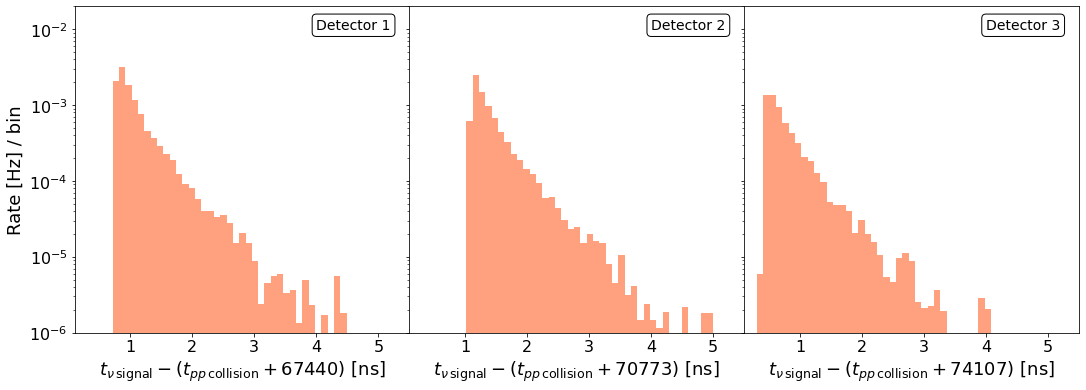

In [47]:
bin_centers = [67440,70773,74107]
bw = 5

fig,ax = plt.subplots(1,3,figsize=(18,6),sharey=True)
fig.subplots_adjust(wspace=0)
for ib,bc in enumerate(bin_centers):
    d,b,_ = ax[ib].hist(nu_data["beam_timing"]-bc,weights=nu_data["weights"]/n_seconds_HLLHC,
                bins=np.linspace(0,bw,50),#np.linspace(bc-bw/2,bc+bw/2,100),
                alpha=0.5,color=nu_color,label="Neutrino Signal")
    print(sum(d[b[:-1]>3])/sum(d))
    ax[ib].set_xlabel(r"$t_{\nu\,{\rm signal}} - (t_{pp\,{\rm collision}} + %d)$ [ns]"%bc)
    ax[ib].text(bw-1,0.01,"Detector %d"%(ib+1),fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
    ax[ib].semilogy()
    ax[ib].set_xlim(0.1,bw+0.5)
    ax[ib].set_xticks(range(1,bw+1))
ax[0].set_ylabel("Rate [Hz] / bin")
ax[0].set_ylim(1e-6,2e-2)
plt.savefig("Figures/BeamTiming.pdf",dpi=100)
plt.show()


## Time delay between scintillator hits

In [48]:
cosmic_data["delta_t"] = np.sqrt((cosmic_data.int2_x - cosmic_data.int1_x)**2 + 
                                 (cosmic_data.int2_y - cosmic_data.int1_y)**2 + 
                                 (cosmic_data.int2_z - cosmic_data.int1_z)**2) /c
nu_data["delta_t"] = np.sqrt((nu_data.second_plane_x - nu_data.first_plane_x)**2 + 
                             (nu_data.second_plane_y - nu_data.first_plane_y)**2 + 
                             (nu_data.second_plane_z - nu_data.first_plane_z)**2) /c

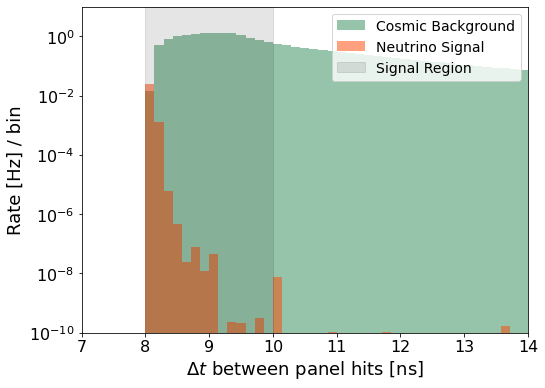

True coincidence rate w/ time cut =  13.234512760428007
Accidnetal coincidence rate w/ time cut =  0.0001963971906379869


In [49]:
plt.hist(cosmic_data["delta_t"],bins=np.linspace(7,14,50),weights=rate/Ngen*np.ones_like(cosmic_data["delta_t"]),
         alpha=0.5,color=cosmic_color,label="Cosmic Background")
plt.hist(nu_data["delta_t"],bins=np.linspace(7,14,50),weights=nu_data["weights"]/n_seconds_HLLHC,
         alpha=0.5,color=nu_color,label="Neutrino Signal")
plt.fill_between([8,10],[10,10],color="black",alpha=0.1,label="Signal Region")
plt.semilogy()
plt.ylim(1e-10,10)
plt.xlim(7,14)
plt.xlabel(r"$\Delta t$ between panel hits [ns]")
plt.ylabel("Rate [Hz] / bin")
plt.legend(loc="upper right")
plt.savefig("Figures/Panel_DeltaT.pdf",dpi=100)
plt.show()

cosmic_data_time_cut = cosmic_data.query("delta_t > 8 and delta_t < 10")
nu_data_time_cut = nu_data.query("delta_t > 8 and delta_t < 10")
print("True coincidence rate w/ time cut = ",len(cosmic_data_time_cut)*rate/Ngen)
print("Accidnetal coincidence rate w/ time cut = ",singles_rate* 1.62e3 * 2e-9)

# Spatial Cuts

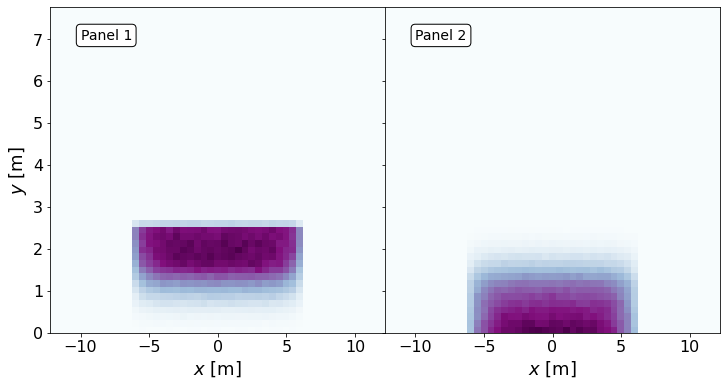

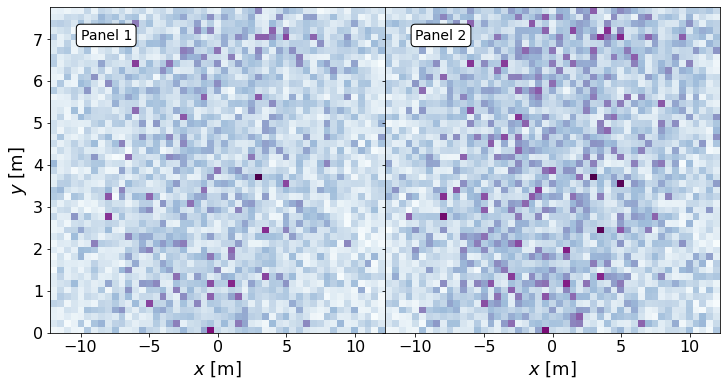

In [50]:
fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True)
fig.subplots_adjust(wspace=0)
ybins = np.linspace(-12.2,12.2,50)
zbins = np.linspace(0,7.77,50)

ax[0].hist2d(cosmic_data["first_plane_y"],cosmic_data["first_plane_z"],bins=(ybins,zbins))
ax[1].hist2d(cosmic_data["second_plane_y"],cosmic_data["second_plane_z"],bins=(ybins,zbins))
ax[0].set_xlabel(r"$x$ [m]")
ax[0].set_ylabel(r"$y$ [m]")
ax[1].set_xlabel(r"$x$ [m]")
ax[0].text(-10,7,"Panel 1",fontsize=14,
           bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
ax[1].text(-10,7,"Panel 2",fontsize=14,
           bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
plt.savefig("Figures/Panel1Panel2_cosmics.pdf",dpi=100)
plt.show()

fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True)
fig.subplots_adjust(wspace=0)
xbins = np.linspace(-12.2,12.2,50)
ybins = np.linspace(0,7.77,50)


ax[0].hist2d(nu_data["first_plane_x"],nu_data["first_plane_y"],bins=(xbins,ybins),weights=nu_data["weights"])
ax[1].hist2d(nu_data["second_plane_x"],nu_data["second_plane_y"],bins=(xbins,ybins),weights=nu_data["weights"])
ax[0].set_xlabel(r"$x$ [m]")
ax[0].set_ylabel(r"$y$ [m]")
ax[1].set_xlabel(r"$x$ [m]")
ax[0].text(-10,7,"Panel 1",fontsize=14,
           bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
ax[1].text(-10,7,"Panel 2",fontsize=14,
           bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
plt.savefig("Figures/Panel1Panel2_neutrinos.pdf",dpi=100)
plt.show()

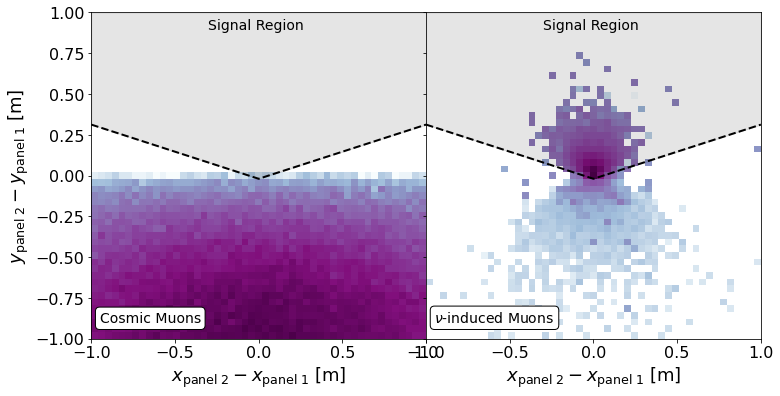

In [51]:
vertical_cut = -0.02
horizontal_cut = 0.05
opening_angle = 2.5
cut = "2Dtr"

fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True)
fig.subplots_adjust(wspace=0)

cos_map = ax[0].hist2d(cosmic_data["horizontal_displacement"],cosmic_data["vertical_displacement"],
                       bins=np.linspace(-1,1,50),weights=rate/Ngen*n_seconds_HLLHC*np.ones(len(cosmic_data)),
                       norm=LogNorm())
nu_map = ax[1].hist2d(nu_data["horizontal_displacement"],nu_data["vertical_displacement"],
                      bins=np.linspace(-1,1,50),weights=nu_dict["weights"],
                      norm=LogNorm())

if cut=="1D":
    xs = [-1,1]
    ys = [vertical_cut,vertical_cut]
    
elif cut=="2Dsq":
    xs = [-horizontal_cut,-horizontal_cut,horizontal_cut,horizontal_cut]
    ys = [1,vertical_cut,vertical_cut,1]
if cut=="2Dtr":
    xs = [-1,0,1]
    ys = [1./np.tan(opening_angle/2) + vertical_cut, vertical_cut, 1./np.tan(opening_angle/2) + vertical_cut]
    for i in range(2): ax[i].text(-0.3,0.9,"Signal Region",color="black",alpha=1,fontsize=14)
else:
    xs=[]
    yx=[]
if xs and ys: 
    for i in range(2): 
        ax[i].plot(xs,ys,color="black",ls="--")
        ax[i].fill_between(xs,ys,np.ones_like(ys),color="black",alpha=0.1)
    
ax[0].text(-0.95,-0.9,"Cosmic Muons",fontsize=14,bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
ax[1].text(-0.95,-0.9,r"$\nu$-induced Muons",fontsize=14,bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))
for i in range(2): 
    ax[i].set_xlabel(r"$x_{\rm panel\;2} - x_{\rm panel\;1}$ [m]")
ax[0].set_ylabel(r"$y_{\rm panel\;2} - y_{\rm panel\;1}$ [m]")
plt.savefig("Figures/PanelDeltaSpatial.pdf",dpi=100)
plt.show()

# Vertical Cut

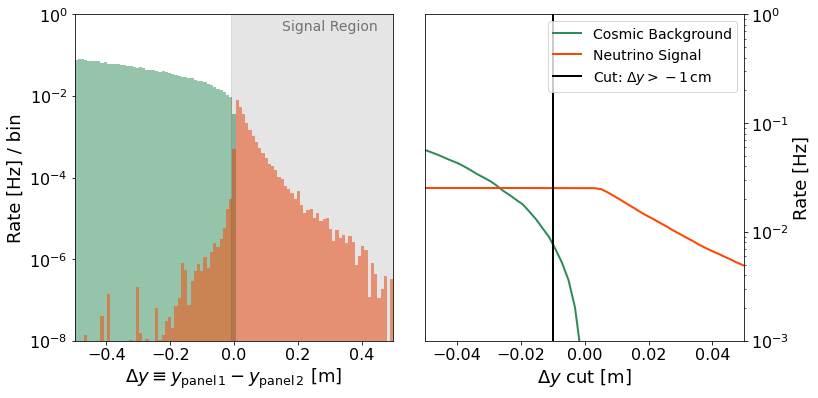

224
0.025296787313542495 0.007931940029688275


In [52]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.subplots_adjust(wspace=0.1)

ax[0].hist(cosmic_data_time_cut["muon_height_difference"],bins=np.linspace(-0.5,0.5,100),weights=rate/Ngen*np.ones_like(cosmic_data_time_cut["muon_height_difference"]),
           alpha=0.5,label="Cosmic Background",color=cosmic_color)
ax[0].hist(nu_data_time_cut["muon_height_difference"],bins=np.linspace(-0.5,0.5,100),weights=nu_data_time_cut["weights"]/n_seconds_HLLHC,
           alpha=0.5,label="Neutrino Signal",color=nu_color)
vertical_resolution_array = np.linspace(-0.05,0.05,50)
bkg_rate = np.empty_like(vertical_resolution_array)
sig_rate = np.empty_like(vertical_resolution_array)
for i,vertical_cut in enumerate(vertical_resolution_array):
    num_bkg = sum(cosmic_data_time_cut["muon_height_difference"] >= vertical_cut)
    num_sig = sum(nu_data_time_cut.query("muon_height_difference > @vertical_cut")["weights"])
    bkg_rate[i] = rate*num_bkg/Ngen
    sig_rate[i] = num_sig / n_seconds_HLLHC
ax[1].plot(vertical_resolution_array,bkg_rate,label="Cosmic Background",color=cosmic_color)
ax[1].plot(vertical_resolution_array,sig_rate,label="Neutrino Signal",color=nu_color)
ax[0].fill_between([-0.01,0.5],[1,1],color="black",alpha=0.1)
ax[0].text(0.15,0.4,"Signal Region",color="black",alpha=0.5,fontsize=14)
ax[0].set_xlim(-0.5,0.5)
ax[0].set_ylim(1e-8,1)
ax[1].plot([-0.01,-0.01],[1e-3,1e0],color="black",label=r"Cut: $\Delta y > -1\,$cm")
ax[1].set_xlim(vertical_resolution_array[0],vertical_resolution_array[-1])
ax[1].set_ylim(1e-3,1)
ax[0].semilogy()
ax[1].legend()
ax[1].semilogy()
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

ax[0].set_xlabel(r"$\Delta y \equiv y_{\rm panel\,1} - y_{\rm panel\,2}$ [m]")
ax[0].set_ylabel(r"Rate [Hz] / bin")
ax[1].set_xlabel(r"$\Delta y$ cut [m]")
ax[1].set_ylabel(r"Rate [Hz]")
plt.savefig("Figures/VerticalCut.pdf",dpi=100)
plt.show()

vertical_cut = -0.01
num_bkg = sum(cosmic_data_time_cut["muon_height_difference"] >= vertical_cut)
print(num_bkg)
num_sig = sum(nu_data_time_cut.query("muon_height_difference > @vertical_cut")["weights"])
bkg_rate = rate*num_bkg/Ngen
sig_rate = num_sig / n_seconds_HLLHC
print(sig_rate,bkg_rate)

# 2D Cut

In [53]:
N = 75
vertical_cut_array = np.linspace(-0.1,0.02,N)
opening_angle_cut_array = np.linspace(0.01,np.pi,N)
#horizontal_cut_array = np.linspace(0.01,0.5,N)

sig_rate = np.zeros((N,N))
bkg_rate = np.zeros((N,N))
for iv,vc in enumerate(vertical_cut_array):
    print(iv)
    for ih,oac in enumerate(opening_angle_cut_array):
        slope = 1./ np.arctan(oac/2)
        cut = "vertical_displacement > @slope * abs(horizontal_displacement) + @vc"
        #cut = "vertical_displacement > @vc and horizontal_displacement > -@hc and horizontal_displacement < @hc"
        num_bkg = len(cosmic_data_time_cut.query(cut))
        num_sig = sum(nu_data_time_cut.query(cut)["weights"])
        sig_rate[iv,ih] = (num_sig/n_seconds_HLLHC)
        bkg_rate[iv,ih] = (rate*num_bkg/Ngen)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


2
0.024480267152124775 7.082089312221673e-05


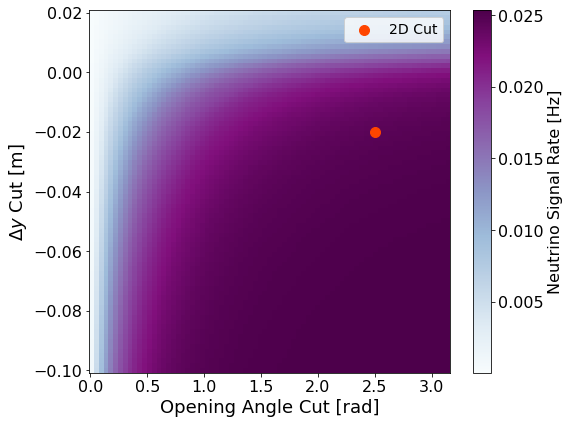

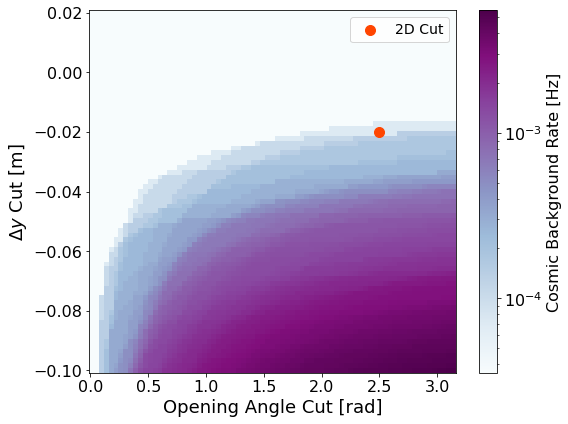

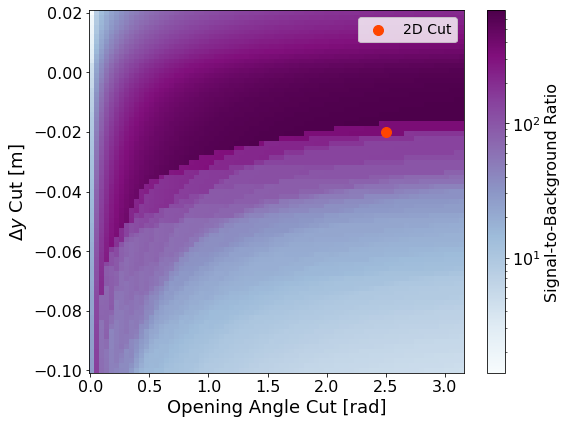

In [54]:
vc = -0.02
oac = 2.5
slope = 1./ np.arctan(oac/2)
cut = "vertical_displacement > @slope * abs(horizontal_displacement) + @vc"
num_bkg = len(cosmic_data_time_cut.query(cut))
num_sig = sum(nu_data_time_cut.query(cut)["weights"])
sig_rate_cut = (num_sig/n_seconds_HLLHC)
bkg_rate_cut = (rate*num_bkg/Ngen)
print(num_bkg)
print(sig_rate_cut,bkg_rate_cut)

plt.pcolormesh(opening_angle_cut_array,vertical_cut_array,sig_rate)
cbar = plt.colorbar()
cbar.set_label("Neutrino Signal Rate [Hz]",fontsize=16)
plt.xlabel("Opening Angle Cut [rad]")
plt.ylabel(r"$\Delta y$ Cut [m]")
plt.scatter([oac],[vc],color=nu_color,label="2D Cut")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/2DCut_Signal.pdf",dpi=100)
plt.show()

bkg_rate_filled = np.where(bkg_rate>0,bkg_rate,np.min(bkg_rate[bkg_rate>0]))

plt.pcolormesh(opening_angle_cut_array,vertical_cut_array,bkg_rate_filled,norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label("Cosmic Background Rate [Hz]",fontsize=16)
plt.xlabel("Opening Angle Cut [rad]")
plt.ylabel(r"$\Delta y$ Cut [m]")
plt.scatter([oac],[vc],color=nu_color,label="2D Cut")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/2DCut_Background.pdf",dpi=100)
plt.show()

sig_bkg_ratio = sig_rate/bkg_rate_filled#np.where(bkg_rate>0,sig_rate/bkg_rate,sig_rate/(rate/Ngen))
# plt.contour(opening_angle_cut_array,vertical_cut_array,sig_bkg_ratio,
#             levels=[1,10],colors="white",linestyles=["-","--"],linewidths=3)
plt.pcolormesh(opening_angle_cut_array,vertical_cut_array,
               sig_bkg_ratio,norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label("Signal-to-Background Ratio",fontsize=16)
plt.xlabel("Opening Angle Cut [rad]")
plt.ylabel(r"$\Delta y$ Cut [m]")
plt.scatter([oac],[vc],color=nu_color,label="2D Cut")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/2DCut_SignalBackgroundRatio.pdf",dpi=100)
plt.show()

